### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [327]:
env = 'pc'  # 'pc', 'colab'
using_gpu = False

In [343]:
%%capture
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/master/'

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [344]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt




In [345]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [346]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (1000, 2), Y: (1000,)


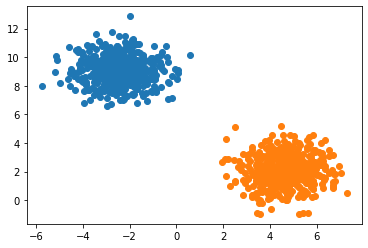

In [347]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 500 instances of object 0.0
We have to delabel 485 instances
Found 500 instances of object 1.0
We have to delabel 485 instances

    We have 970 unlabeled data
    Out of 1000
    


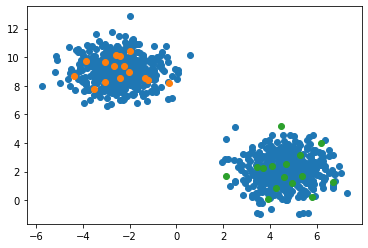

In [348]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [349]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [320]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [321]:
Y_preds_GD = solver.solve(X,Y_delabeled,iter_limit = 5, delta_loss_limit = 0.008,stop_loss = 19.6)

Loss: 154.56245717183577, delta loss: 154.56245717183577
Loss: 152.6864716380263, delta loss: 1.8759855338094837
Loss: 151.11879093982526, delta loss: 1.5676806982010305
Loss: 149.7812038628925, delta loss: 1.3375870769327491
Loss: 148.6212761728861, delta loss: 1.1599276900064126




Accuracy: 1.0


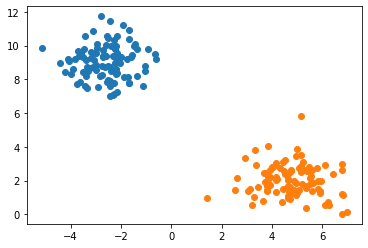

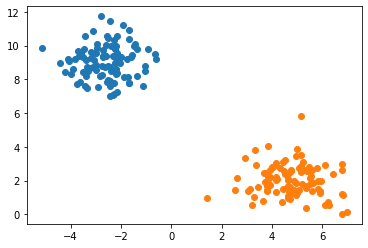

In [322]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

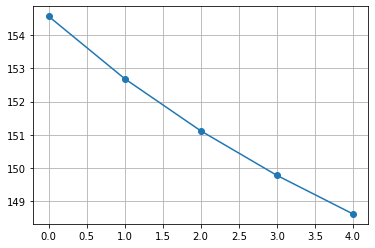

In [323]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [350]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [351]:
X.shape

(1000, 2)

In [352]:
%prun Y_preds_BCGD_permutation = random_solver.solve(X, Y_delabeled, iter_limit = 5, delta_loss_limit = 0.008, stop_loss = 19.6)

Loss: 3556.567205494026, Delta: 3556.567205494026
Loss: 3371.8339342157556, Delta: 184.73327127827042
Loss: 3293.676110845374, Delta: 78.15782337038172
Loss: 3260.867384865326, Delta: 32.80872598004771
Loss: 3245.6385636354107, Delta: 15.228821229915411
 

         126207046 function calls (116507046 primitive calls) in 85.900 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  9700000   27.574    0.000   52.549    0.000 linalg.py:2349(norm)
19409717/9709717   16.619    0.000   58.370    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  9700000   13.667    0.000   77.663    0.000 GradientSolver.py:40(calc_weight)
        5    7.302    1.460   45.058    9.012 GradientSolver.py:57(<listcomp>)
  9700000    5.031    0.000   63.996    0.000 <__array_function__ internals>:177(norm)
  9700000    4.735    0.000   17.214    0.000 <__array_function__ internals>:177(dot)
  9700000    2.530    0.000    2.530    0.000 {method 'ravel' of 'numpy.ndarray' objects}
  9700000    2.124    0.000    3.039    0.000 linalg.py:116(isComplexType)
 19400000    2.086    0.000    2.086    0.000 {built-in method builtins.issubclass}
  9700000    1.158    0.000    1.158    0.00

Accuracy: 1.0


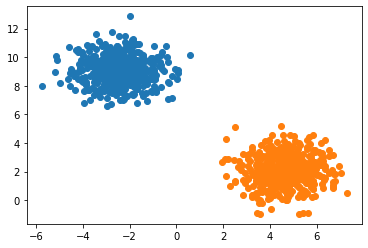

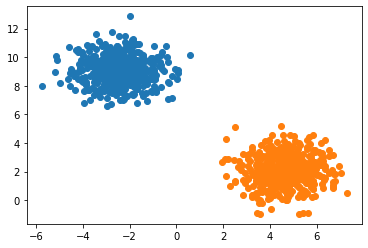

In [355]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

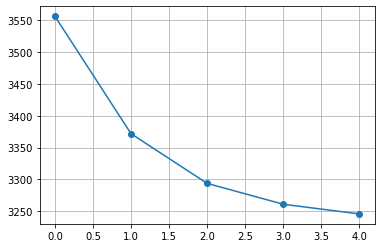

In [354]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

## BCGD random sampling

In [54]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,

    bcgd_strategy = 'random sampling'
)

In [56]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled, 
    iter_limit = 100,
    delta_loss_limit = 0.0,
    stop_loss = 19.7
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 25.133070718616207, Delta: 0.00020891690097712967
LOSS: 25.13302797013207, Delta: 4.2748484137433707e-05
LOSS: 25.132963450995135, Delta: 6.451913693439337e-05
LOSS: 25.132448941582517, Delta: 0.0005145094126177696
LOSS: 25.131940824897555, Delta: 0.00050811668496209
LOSS: 25.13190229268831, Delta: 3.8532209245545346e-05
LOSS: 25.13185458326693, Delta: 4.770942138065948e-05
LOSS: 25.131738238544692, Delta: 0.00011634472223676084
LOSS: 25.131627868639892, Delta: 0.00011036990479951214
LOSS: 25.131541091442454, Delta: 8.677719743843681e-05
LOSS: 25.1314987113759, Delta: 4.238006655299387e-05
LOSS: 25.13133035780234, Delta: 0.0001683535735601538
LOSS: 25.131164302456646, Delta: 0.0001660553456943603
LOSS: 25.131120763414724, Delta: 4.353904192200275e-05
LOSS: 25.130934984134043, Delta: 0.0001857792806809755
LOSS: 25.130522591605185, Delta: 0.00041239252885816313
LOSS: 25.130358744174348, Delta: 0.000163847430837194
LOSS: 25.1301514

Accuracy: 0.9


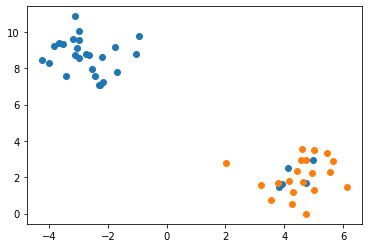

In [57]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

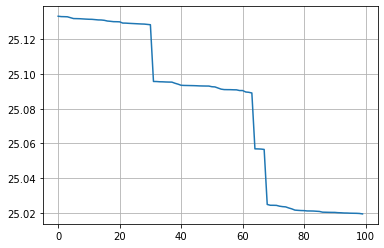

In [58]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

## BCGD cyclic

In [59]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'cyclic'
)

In [60]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    iter_limit = 50, 
    delta_loss_limit = 0.0001,
    stop_loss = 19.8
)

LOSS: 25.133279635517184, Delta: 25.133279635517184
LOSS: 24.688868015546948, Delta: 0.4444116199702357
LOSS: 24.292568602572377, Delta: 0.39629941297457094
LOSS: 23.93796895469215, Delta: 0.354599647880228
LOSS: 23.619581106339318, Delta: 0.31838784835283107
LOSS: 23.332703530945338, Delta: 0.28687757539398007
LOSS: 23.073304105379844, Delta: 0.2593994255654941
LOSS: 22.837920845420673, Delta: 0.2353832599591712
LOSS: 22.623577681859683, Delta: 0.21434316356099004
LOSS: 22.427712969374213, Delta: 0.19586471248547
LOSS: 22.248118777142274, Delta: 0.17959419223193862
LOSS: 22.082889311591394, Delta: 0.1652294655508797
LOSS: 21.930377076276837, Delta: 0.15251223531455693
LOSS: 21.789155588986446, Delta: 0.14122148729039097
LOSS: 21.657987657902584, Delta: 0.13116793108386204
LOSS: 21.53579837222916, Delta: 0.12218928567342502
LOSS: 21.42165209247579, Delta: 0.11414627975337055
LOSS: 21.314732835299225, Delta: 0.10691925717656403
LOSS: 21.21432754053694, Delta: 0.10040529476228599
LOSS: 2

Accuracy: 1.0


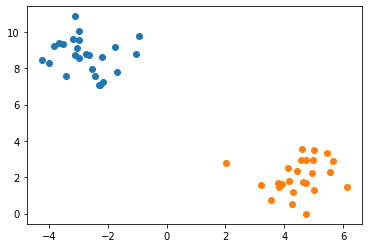

In [61]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

In [62]:
accuracy_score(Y, Y_preds_BCGD_cyclic)

1.0

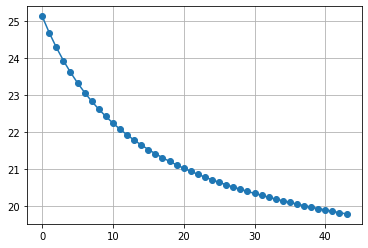

In [63]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [64]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [65]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [67]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [71]:
iters_limit = 100
delta_loss_limit = 0.0001
stop_loss = 19.7

if using_gpu:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()

    with tf.device(device_name):
        print(f'with GPU')
        preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )

else:
    print(f'without GPU')
    preds, losses, n_iters, cpu_times = compare_models(
            solvers,
            X,
            Y_delabeled,
            iters_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss = stop_loss
        )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

without GPU
Loss: 25.133279635517184, delta loss: 25.133279635517184
Loss: 24.692046825881985, delta loss: 0.4412328096351992
Loss: 24.298667083853772, delta loss: 0.3933797420282126
Loss: 23.94673438446902, delta loss: 0.3519326993847507
Loss: 23.63077100177023, delta loss: 0.31596338269879
Loss: 23.346088146351793, delta loss: 0.2846828554184384
Loss: 23.08866792244849, delta loss: 0.25742022390330277
Loss: 22.855063307403576, delta loss: 0.23360461504491425
Loss: 22.642313369598728, delta loss: 0.21274993780484763
Loss: 22.447871373983205, delta loss: 0.19444199561552367
Loss: 22.269543789721443, delta loss: 0.17832758426176198
Loss: 22.105438522836014, delta loss: 0.1641052668854286
Loss: 21.953920956937267, delta loss: 0.15151756589874665
Loss: 21.8135766047739, delta loss: 0.1403443521633676
Loss: 21.683179358736666, delta loss: 0.13039724603723357
Loss: 21.561664484968123, delta loss: 0.1215148737685432
Loss: 21.448105637880257, delta loss: 0.1135588470878659
Loss: 21.3416952834

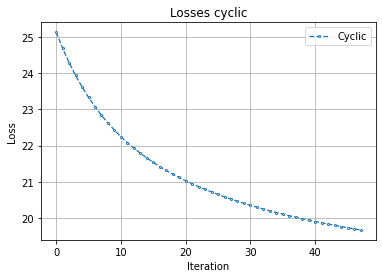

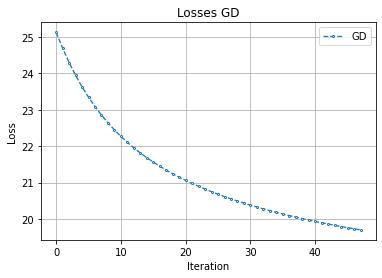

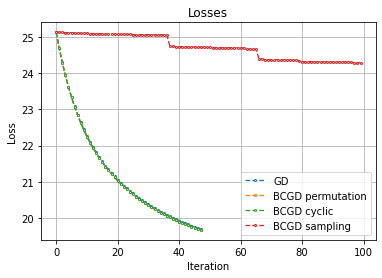

In [72]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots(figsize = (6, 4))

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(losses, 'Losses', y_label = 'Loss')

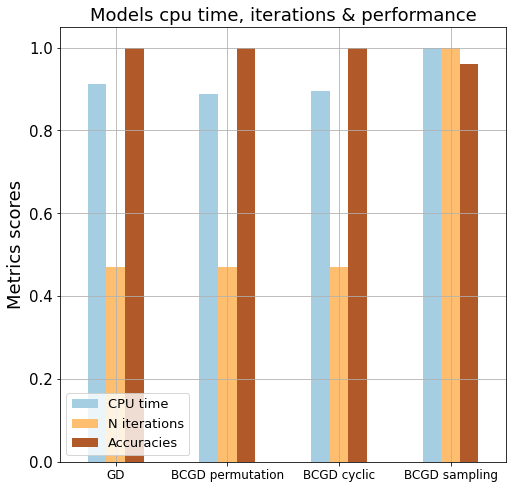

In [73]:
def plot_bar_metrics(metrics_df):
    
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired',
        figsize = (8, 8)
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

In [74]:
print(accuracies)
print(n_iters)
print(cpu_times)

{'GD': 1.0, 'BCGD permutation': 1.0, 'BCGD cyclic': 1.0, 'BCGD sampling': 0.96}
{'GD': 47, 'BCGD permutation': 47, 'BCGD cyclic': 47, 'BCGD sampling': 100}
{'GD': 1.6719717999999375, 'BCGD permutation': 1.6277214000000413, 'BCGD cyclic': 1.6390458000000763, 'BCGD sampling': 1.8320298000001003}


# Real dataset

In [23]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

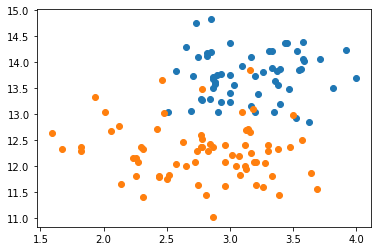

In [24]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [25]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = 0.06, # DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 55 instances
Found 71 instances of object 1.0
We have to delabel 66 instances


In [1]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

NameError: name 'plot_clusters' is not defined

In [2]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iter_limit=50,
    delta_loss_limit = 0.003
)

NameError: name 'GradientDescentSolver' is not defined

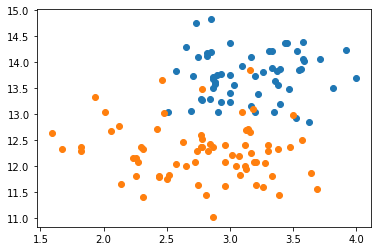

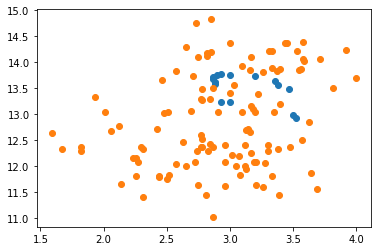

In [29]:
plot_clusters(
    X_real,
    Y_real
)
plot_clusters(
    X_real,
    Y_real_preds
)